In [297]:
!pip install torchsummary

In [298]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv, GraphConv
from torch.nn.utils.parametrizations import weight_norm
from torch_geometric.nn import ChebConv
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report

import random
import glob
import os
import json
import pickle

import warnings
warnings.filterwarnings("ignore")

# Fix seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [299]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [300]:
DATA_PATH = 'data/subdata_extended'
STARTING_MODEL_PATH = None

FOLDER_MODEL_SAVE = f'new_models/temporal_sandwich_model_with_gate_data_shuffled_edge_weight_batch_16_subdata_extended_batch_norm_attentionSpatial'
os.makedirs(FOLDER_MODEL_SAVE)

# Model

In [301]:
VERBOSE = False

In [302]:
class SimpleTemporalConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(SimpleTemporalConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), stride=(1, stride), padding=(0, padding))
        self.conv2 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), stride=(1, stride), padding=(0, padding))
        self.conv3 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), stride=(1, stride), padding=(0, padding))
        
        self.batch_norm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = x.permute(0, 3, 2, 1)  # (B, T, N, C) -> (B, C, N, T)
        
        P = self.conv1(x)
        Q = torch.sigmoid(self.conv2(x))
        PQ = P * Q
        PQ = self.batch_norm(PQ)
        x = F.relu(PQ + self.conv3(x))

        x=x.permute(0, 3, 2, 1)  # Back to (B, T, N, C)
        
        return x
    
    
    
class SimpleTemporalDeConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(SimpleTemporalDeConv, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(in_channels, out_channels, (1, kernel_size), stride=(1, stride), padding=(0, padding))
        self.deconv2 = nn.ConvTranspose2d(in_channels, out_channels, (1, kernel_size), stride=(1, stride), padding=(0, padding))
        self.deconv3 = nn.ConvTranspose2d(in_channels, out_channels, (1, kernel_size), stride=(1, stride), padding=(0, padding))

    def forward(self, x):
        if VERBOSE: print("Temporal DeConv")
        
        x = x.permute(0, 3, 2, 1)  # (B, T, N, C) -> (B, C, N, T)
        
        P = self.deconv1(x)
        Q = torch.sigmoid(self.deconv2(x))
        PQ = P * Q
        x = F.relu(PQ + self.deconv3(x))
        
        x=x.permute(0, 3, 2, 1) # Back to (B, T, N, C)
        
        return x 


In [303]:
class SimpleSpatialConv(nn.Module):
    def __init__(self, in_channels, out_channels, K, normalization='sym', bias=False):
        super(SimpleSpatialConv, self).__init__()
        self.conv = ChebConv(in_channels, out_channels, K, normalization=normalization, bias=bias)
        
        # Attention computation layers
        self.attention_fc = nn.Linear(out_channels, 1)  # Compute scalar attention per node/channel
        self.softmax = nn.Softmax(dim=1)  # Normalize attention scores along nodes

    def forward(self, x, edge_index, edge_weight):
        """
        x: Input tensor of shape (B, T, N, C)
        edge_index, edge_weight: Graph edges and weights for ChebConv
        """
        batch_size, time_steps, num_nodes, _ = x.size()
        output = torch.zeros(batch_size, time_steps, num_nodes, self.conv.out_channels, device=x.device)
        
        for t in range(time_steps):
            # Apply graph convolution
            conv_output = self.conv(x[:, t], edge_index, edge_weight)  # Shape: (B, N, C_out)

            # Compute attention scores
            attention_scores = self.attention_fc(conv_output)  # Shape: (B, N, 1)
            attention_scores = self.softmax(attention_scores)  # Normalize: (B, N, 1)

            # Apply attention
            attended_output = conv_output * attention_scores  # Element-wise multiplication
            
            # Activation (ReLU)
            output[:, t] = F.relu(attended_output)
        
        return output


In [304]:
class SimpleEncoder(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels , kernel_size, stride, padding, K):
        super(SimpleEncoder, self).__init__()
        self.temporal_conv = SimpleTemporalConv(input_channels, input_channels, kernel_size, stride, padding)
        self.graph_conv = SimpleSpatialConv(input_channels, hidden_channels, K)
        self.temporal_conv_2 = SimpleTemporalConv(hidden_channels, output_channels, kernel_size, stride, padding)
        
    def forward(self, x, edge_index, edge_weight=None):
        x = self.temporal_conv(x)
        x = self.graph_conv(x, edge_index, edge_weight)
        x = self.temporal_conv_2(x)
        
        return x
        

class SimpleDecoder(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels, kernel_size, stride, padding, K):    
        super(SimpleDecoder, self).__init__()
        self.temporal_deconv = SimpleTemporalDeConv(input_channels, hidden_channels, kernel_size, stride, padding)
        self.graph_deconv = SimpleSpatialConv(hidden_channels, output_channels, K)
        self.temporal_deconv_2 = SimpleTemporalDeConv(output_channels, output_channels, kernel_size, stride, padding)
        
    def forward(self, x, edge_index, edge_weight=None):
        x = self.temporal_deconv(x)
        x = self.graph_deconv(x, edge_index, edge_weight)
        x = self.temporal_deconv_2(x)
        
        return x
        

In [305]:
class SimpleSTConvAE(nn.Module):
    def __init__(self, device, channel_size_list, num_layers, 
                 kernel_size, K, stride, padding,\
                 normalization = 'sym' , bias = True):
        
        super(SimpleSTConvAE, self).__init__()
        self.layers = nn.ModuleList([])
        # add STConv blocks
        for l in range(num_layers):
            input_size, hidden_size, output_size = channel_size_list[l][0], channel_size_list[l][1], channel_size_list[l][2]
            if l==0:
                self.layers.append(SimpleEncoder(input_size, hidden_size, output_size, kernel_size, stride, padding, K))
            if l==1:
                self.layers.append(SimpleDecoder(input_size, hidden_size, output_size, kernel_size, stride, padding, K))
                
        for layer in self.layers:
            layer = layer.to(device)
            
    def forward(self, x, edge_index, edge_weight=None):
        
        for layer in self.layers:
            x = layer(x, edge_index, edge_weight)
        return x
    
    


# Data preparation

In [306]:
TRAIN_RATIO = 0.7  # Training ratio
VAL_RATIO = 0.15  # Validation ratio
TEST_RATIO = 0.15  # Test ratio

TRAIN_BATCH_SIZE = 16  # Batch size training
VAL_BATCH_SIZE = 16  # Batch size validation
TEST_BATCH_SIZE = 1  # Batch size test

TIME_STEPS = 4*4  # Number of time steps (DAYS)

In [307]:
# Input [batch_size, time_steps, num_nodes, num_features]
def load_data(FOLDER, CORRUPT_FOLDER=None, CORRUPT_PROB=0.0, seed=42):
    if seed:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
    
    file_paths = glob.glob(f'{FOLDER}/node_features_*.pt')  # Percorso per tutti i file CSV
    num_files = len(file_paths)
    step = 1  # Offset per la finestra scorrevole

    # Carica tutti i file in una lista
    all_data = [torch.load(file_path) for file_path in file_paths]  # Ogni file è (num_nodes, num_features)
    all_data_corr = all_data.copy()

    if CORRUPT_FOLDER:
        indices = np.zeros(len(all_data_corr))
        corrupt_file_paths = glob.glob(f'{CORRUPT_FOLDER}/node_features_*.pt')
        corrupt_data = [torch.load(file_path) for file_path in corrupt_file_paths]
        for i in range(len(all_data_corr)):
            if random.random() < CORRUPT_PROB:
                all_data_corr[i] = corrupt_data[i]
                indices[i] = 1

    # Numero di nodi e feature dai dati
    num_nodes, num_features = all_data[0].shape

    # Crea le finestre temporali
    windows = []
    windows_corr = []
    indices_stacked = []
    for i in range(0, num_files - TIME_STEPS + 1, step):
        window = torch.stack(all_data[i:i + TIME_STEPS], dim=0)  # Raggruppa 10 giorni
        windows.append(window)

        if CORRUPT_FOLDER:
            window_corr = torch.stack(all_data_corr[i:i + TIME_STEPS], dim=0)
            windows_corr.append(window_corr)
            indices_stacked.append(int(indices[i:i + TIME_STEPS].sum()))

    # Concatena le finestre temporali
    data = torch.stack(windows, dim=0)

    if CORRUPT_FOLDER:
        data_corr = torch.stack(windows_corr, dim=0)

        # Shuffle data and indices together
        combined = list(zip(data, indices_stacked, data_corr))
        random.shuffle(combined)
        data, indices_stacked, data_corr = zip(*combined)

        # Convert back to tensors and lists
        data = torch.stack(data)
        data_corr = torch.stack(data_corr)
        indices_stacked = list(indices_stacked)

        return data, indices_stacked, data_corr

    # Shuffle data if no corrupt folder is used
    data = data[torch.randperm(data.size(0))]

    return data, num_nodes, num_features


In [308]:
data, num_nodes, num_features= load_data(DATA_PATH)

In [309]:
edge_index = torch.load('node_connections/edge_index.pt').to(device)
edge_weight = torch.load('node_connections/edge_weight.pt').to(device)

edge_index.shape, edge_weight.shape

(torch.Size([2, 12564]), torch.Size([12564]))

In [310]:
# Create train, validation and test sets
train_data = data[:int(TRAIN_RATIO*len(data))]
val_data = data[int(TRAIN_RATIO*len(data)):int((TRAIN_RATIO+VAL_RATIO)*len(data))]
test_data = data[int((TRAIN_RATIO+VAL_RATIO)*len(data)):]

train_loader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_data, batch_size=VAL_BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False)

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

print(edge_index.shape)

print(f'Number of training batches: {len(train_loader)}')
print(f'Number of validation batches: {len(val_loader)}')
print(f'Number of test batches: {len(test_loader)}')


torch.Size([161, 16, 1657, 8])
torch.Size([34, 16, 1657, 8])
torch.Size([35, 16, 1657, 8])
torch.Size([2, 12564])
Number of training batches: 11
Number of validation batches: 3
Number of test batches: 35


In [311]:
# Print info overall
print(f"Number of training graphs: {len(train_data)}")
print(f"Number of validation graphs: {len(val_data)}")
print(f"Number of test graphs: {len(test_data)}")
print()
#Print info for each graph

data=train_data[0]
print(f"Graph: {data.size()}")
print(f"Number of time series: {data.size(0)}")
print(f"Number of nodes: {data.size(1)}")
print(f"Number of features: {data.size(2)}")
print(f"Number of edges: {edge_index.size(1)}")
print(f"Edge index shape: {edge_index.shape}")
print(f"Edge weight shape: {edge_weight.shape}")
print()
    
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Save this info into a json file
data_info = {
    'data_augmented': True if DATA_PATH == 'augmented_data' else False,
    'num_nodes': num_nodes,
    'num_features': num_features,
    'time_steps': TIME_STEPS,
    'train_ratio': TRAIN_RATIO,
    'val_ratio': VAL_RATIO,
    'test_ratio': TEST_RATIO,
    'train_batch_size': TRAIN_BATCH_SIZE,
    'val_batch_size': VAL_BATCH_SIZE,
    'test_batch_size': TEST_BATCH_SIZE,
    'num_train_batches': len(train_loader),
    'num_val_batches': len(val_loader),
    'num_test_batches': len(test_loader),
    'edge_index_shape': edge_index.shape,
    'edge_weight_shape': edge_weight.shape
}

with open(FOLDER_MODEL_SAVE+'/data_info.json', 'w') as f:
    json.dump(data_info, f, indent=4)

Number of training graphs: 161
Number of validation graphs: 34
Number of test graphs: 35

Graph: torch.Size([16, 1657, 8])
Number of time series: 16
Number of nodes: 1657
Number of features: 8
Number of edges: 12564
Edge index shape: torch.Size([2, 12564])
Edge weight shape: torch.Size([12564])

Number of training batches: 11
Number of validation batches: 3
Number of test batches: 35


# Hyperparameters

In [312]:
# Parameters
filters_list = [[num_features, 16, 32], [32, 16, num_features]]
num_layers = 2
kernel_size = 4             # Temporal convolution kernel size
stride = 2                 # Temporal convolution stride
padding = 1                 # Temporal convolution padding
K = 3                       # Chebyshev polynomial order for graph convolution

In [313]:
model = SimpleSTConvAE(
        device, 
        filters_list, 
        num_layers, 
        kernel_size, 
        K,
        stride, 
        padding
    ).to(device)

sum(p.numel() for p in model.parameters() if p.requires_grad)

14890

In [314]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = None

In [315]:
# Save hyperparameters and model architecture

model_info = {
    'model': 'SimpleSTConvAE',
    'num_layers': num_layers,
    'kernel_size': kernel_size,
    'K': K,
    'stride': stride,
    'padding': padding,
    'filters_list': filters_list,
    'optimizer': optimizer.__str__(),
    'criterion': criterion.__str__(),
    'scheduler': 'None' if scheduler is None else scheduler.__str__(),
    'num_params': sum(p.numel() for p in model.parameters() if p.requires_grad)
}

with open(FOLDER_MODEL_SAVE+'/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)
    
# Save model architecture
with open(FOLDER_MODEL_SAVE+'/model_architecture.txt', 'w') as f:
    f.write(str(model))

# Functions definition

In [316]:
# Funzione di validazione per valutare il modello
def evaluate(model, loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)  # Move data to device
            output = model(data, edge_index, edge_weight)
            loss = criterion(output, data)
            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(loader)
    return avg_val_loss

In [317]:
def train(device, model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, early_stopping=30):
    
    train_losses = []
    val_losses = []
    
    best_val_loss = float("inf")  # Initialize the best validation loss to infinity

    
    for epoch in range(num_epochs):
        model.train()
        loss = 0
        train_loss=0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data, edge_index, edge_weight)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
            
        val_loss = evaluate(model, val_loader, criterion, device)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')
        
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        
        if scheduler:
            scheduler.step(val_loss)
            
        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss  # Update the best validation loss
            torch.save(model.state_dict(), os.path.join(FOLDER_MODEL_SAVE, 'best_model.pth'))
            
        # Early stopping
        if early_stopping!=None and epoch > early_stopping and val_losses[-1] > val_losses[-(early_stopping+1)]:
            print(f"Validation loss has not improved over the last {early_stopping} epochs, stopping early.")
            break
            
    return train_losses, val_losses

# Training

In [318]:
num_epochs = 50

In [319]:
train_losses, val_losses = train(device, model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

Epoch 1/50, Loss: 0.5945, Val Loss: 0.5523
Epoch 2/50, Loss: 0.5932, Val Loss: 0.5515
Epoch 3/50, Loss: 0.5921, Val Loss: 0.5510
Epoch 4/50, Loss: 0.5915, Val Loss: 0.5508
Epoch 5/50, Loss: 0.5912, Val Loss: 0.5508
Epoch 6/50, Loss: 0.5910, Val Loss: 0.5508
Epoch 7/50, Loss: 0.5908, Val Loss: 0.5508
Epoch 8/50, Loss: 0.5907, Val Loss: 0.5508
Epoch 9/50, Loss: 0.5907, Val Loss: 0.5508
Epoch 10/50, Loss: 0.5906, Val Loss: 0.5508
Epoch 11/50, Loss: 0.5906, Val Loss: 0.5508
Epoch 12/50, Loss: 0.5906, Val Loss: 0.5508
Epoch 13/50, Loss: 0.5906, Val Loss: 0.5508
Epoch 14/50, Loss: 0.5906, Val Loss: 0.5508
Epoch 15/50, Loss: 0.5906, Val Loss: 0.5508
Epoch 16/50, Loss: 0.5906, Val Loss: 0.5508
Epoch 17/50, Loss: 0.5906, Val Loss: 0.5508
Epoch 18/50, Loss: 0.5906, Val Loss: 0.5508
Epoch 19/50, Loss: 0.5906, Val Loss: 0.5508
Epoch 20/50, Loss: 0.5906, Val Loss: 0.5508
Epoch 21/50, Loss: 0.5906, Val Loss: 0.5508
Epoch 22/50, Loss: 0.5906, Val Loss: 0.5508
Epoch 23/50, Loss: 0.5906, Val Loss: 0.55

In [320]:
# Save the loss variables
with open(FOLDER_MODEL_SAVE+'/loss_variables.pkl', 'wb') as f:
    pickle.dump((train_losses, val_losses), f)

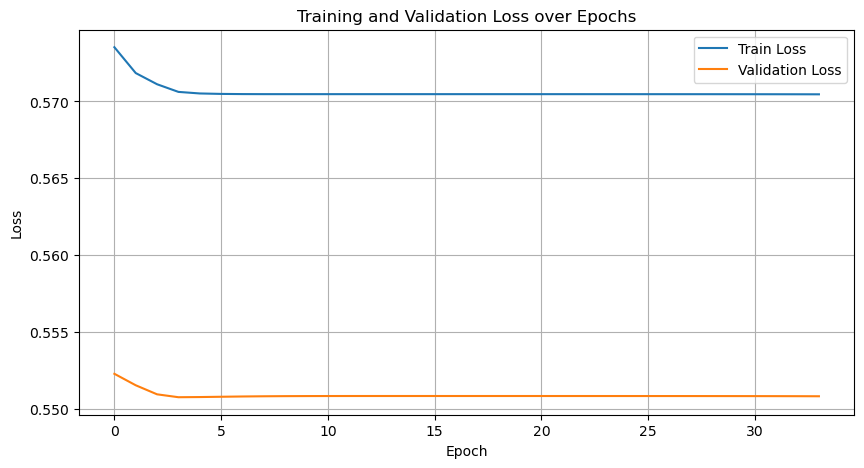

In [321]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig(FOLDER_MODEL_SAVE+'/loss_plot.png')
plt.show()


# Testing

In [322]:
model.load_state_dict(torch.load(FOLDER_MODEL_SAVE+'/best_model.pth'))
model.to(device)

SimpleSTConvAE(
  (layers): ModuleList(
    (0): SimpleEncoder(
      (temporal_conv): SimpleTemporalConv(
        (conv1): Conv2d(8, 8, kernel_size=(1, 4), stride=(1, 2), padding=(0, 1))
        (conv2): Conv2d(8, 8, kernel_size=(1, 4), stride=(1, 2), padding=(0, 1))
        (conv3): Conv2d(8, 8, kernel_size=(1, 4), stride=(1, 2), padding=(0, 1))
        (batch_norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (graph_conv): SimpleSpatialConv(
        (conv): ChebConv(8, 16, K=3, normalization=sym)
        (attention_fc): Linear(in_features=16, out_features=1, bias=True)
        (softmax): Softmax(dim=1)
      )
      (temporal_conv_2): SimpleTemporalConv(
        (conv1): Conv2d(16, 32, kernel_size=(1, 4), stride=(1, 2), padding=(0, 1))
        (conv2): Conv2d(16, 32, kernel_size=(1, 4), stride=(1, 2), padding=(0, 1))
        (conv3): Conv2d(16, 32, kernel_size=(1, 4), stride=(1, 2), padding=(0, 1))
        (batch_norm): BatchNorm2d(32

In [323]:
def detect_anomalies(model, test_loader, criterion, threshold=None, device=device):
    model.eval()
    losses = []

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)  # Move data to device
            output = model(data, edge_index, edge_weight)
            loss = criterion(output, data)
            losses.append(loss.item())

    
    # Se non fornisci un threshold, usiamo ad esempio la media + 2*deviazione standard come soglia
    if threshold is None:
        threshold = np.mean(losses) #+ 1 * np.std(losses)
    
    # Identifica le anomalie
    anomalies = [i for i, loss in enumerate(losses) if loss > threshold]
    
    return losses, threshold, anomalies


In [324]:
mapping_variables = {
    0 : 'solar_zenith_angle',
    1 : 'solar_azimuth_angle',
    2 : 'surf_air_temp_masked',
    3 : 'surf_temp_masked',
    4 : 'surf_spec_hum_masked',
    5 : 'h2o_vap_tot_masked',
    6 : 'cloud_liquid_water_masked',
    7 : 'atmosphere_mass_content_of_cloud_ice_masked'
}

In [325]:
corruption_level = 0.3
variables = [1, 7]  # Features to corrupt
variables.sort()
FOLDER_CORRUPTION = '_'.join([str(mapping_variables[variable]) for variable in variables])
DATA_PATH_TEST = 'data/subdata'
DATA_PATH_CORRUPTED = 'data/subdata_corrupted/'

data, indices, data_corrupted= load_data(DATA_PATH_TEST,DATA_PATH_CORRUPTED+FOLDER_CORRUPTION, corruption_level)
test_data = data[int((TRAIN_RATIO+VAL_RATIO)*len(data)):]
test_loader = DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False)

indices = indices[int((TRAIN_RATIO+VAL_RATIO)*len(data_corrupted)):]
data_corrupted = data_corrupted[int((TRAIN_RATIO+VAL_RATIO)*len(data_corrupted)):]

mixed_loader = DataLoader(data_corrupted, batch_size=TEST_BATCH_SIZE, shuffle=False)

In [326]:
# Esegui il rilevamento delle anomalie
test_losses, anomaly_threshold, anomalies  = detect_anomalies(model, test_loader, criterion, threshold=None, device=device)

print(f"Anomaly Threshold: {anomaly_threshold}")
print(f"Detected Anomalies at indices: {anomalies}")

Anomaly Threshold: 0.5633249247775358
Detected Anomalies at indices: [1, 3, 7, 8, 9, 10, 13]


In [327]:
# Detect anomalies in the mixed data
mixed_losses, _, mixed_anomalies = detect_anomalies(model, mixed_loader, criterion, threshold=anomaly_threshold)

print(f"Detected Anomalies in Mixed Data at indices: {mixed_anomalies}")

Detected Anomalies in Mixed Data at indices: [1, 3, 7, 8, 9, 10, 13, 14]


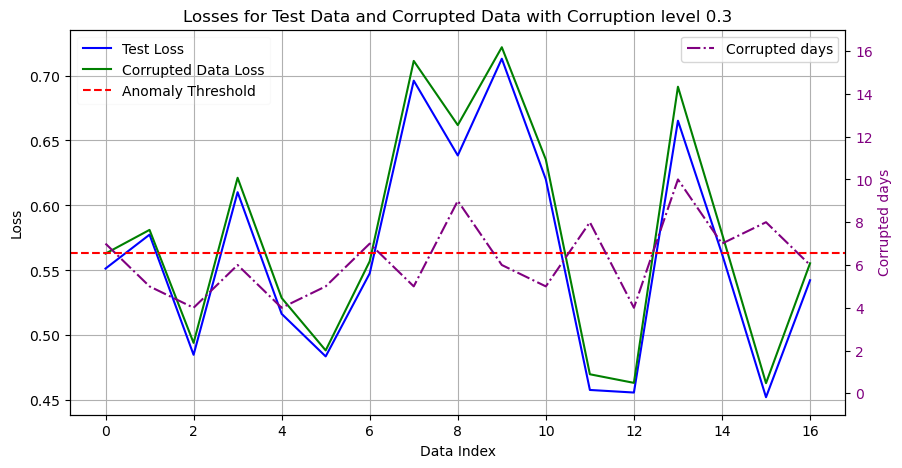

In [328]:
# Plot the losses for the test data and corrupted data with separate axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Primary y-axis for losses
ax1.plot(test_losses, label='Test Loss', color='blue')
ax1.plot(mixed_losses, label='Corrupted Data Loss', color='green')
ax1.axhline(anomaly_threshold, color='red', linestyle='--', label='Anomaly Threshold')
ax1.set_xlabel('Data Index')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left', framealpha=0.1)
ax1.grid(True)
ax1.set_title('Losses for Test Data and Corrupted Data with Corruption level ' + str(corruption_level))

# Secondary y-axis for indices
ax2 = ax1.twinx()
ax2.plot(indices, label='Corrupted days', color='purple', linestyle='-.')
ax2.set_ylabel('Corrupted days', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.set_ylim(-1, 17)  # Set the range of indices between 0 and 16
ax2.legend(loc='upper right')

# Save the plot
plt.savefig(FOLDER_MODEL_SAVE+'/test_corrupted_losses.png')

# Show the plot
plt.show()


In [329]:
# Define the total number of data points (adjust if needed)
total_data_points = len(test_data)

# Create binary lists for actual and predicted anomalies
actual_anomalies = [1 if i>0 else 0 for i in indices]
predicted_anomalies = [1 if i in mixed_anomalies else 0 for i in range(total_data_points)]

# Calculate the metrics
accuracy = accuracy_score(actual_anomalies, predicted_anomalies)
recall = recall_score(actual_anomalies, predicted_anomalies)
precision = precision_score(actual_anomalies, predicted_anomalies)
f1 = f1_score(actual_anomalies, predicted_anomalies)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

# Save the results
results = {
    'Accuracy': accuracy,
    'Recall': recall,
    'Precision': precision,
    'F1 Score': f1,
}

with open(FOLDER_MODEL_SAVE+'/metrics.json', 'w') as f:
    json.dump(results, f, indent=4)

Accuracy: 0.47058823529411764
Recall: 0.47058823529411764
Precision: 1.0
F1 Score: 0.64


In [330]:
print(classification_report(actual_anomalies, predicted_anomalies, target_names=['Normal', 'Anomaly'],labels=[0,1]))

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00         0
     Anomaly       1.00      0.47      0.64        17

    accuracy                           0.47        17
   macro avg       0.50      0.24      0.32        17
weighted avg       1.00      0.47      0.64        17



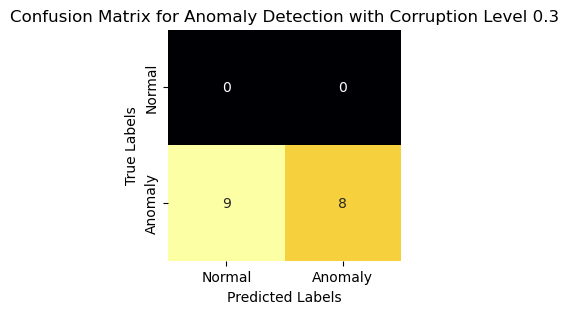

In [331]:
# Plot the confusion matrix
cf = confusion_matrix(actual_anomalies, predicted_anomalies, labels=[0, 1])

plt.figure(figsize=(3,3))
sns.heatmap(cf, annot=True, fmt='d', cmap='inferno', cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Anomaly Detection with Corruption Level ' + str(corruption_level))

plt.savefig(FOLDER_MODEL_SAVE+'/confusion_matrix.png')

plt.show()

In [332]:
# Stop here
# raise SystemExit(0)

### Analysis on different corruption levels
For every couple of variables having an high correlation a different level of corruption is applied. The first is the baseline with a corruption applied to all the variables.

In [333]:
# Feature index pairs to test
correlated_vars = [
# [0, 1],
# [0, 3],
[3],
[2, 3],
# [2, 5],
# [4, 5],
# [0, 1, 3],
# [0, 2, 3]
]

low_correlated_vars = [
# [0, 4],
# [0, 5],
# [0, 6],
# [0, 7],
# [1, 2],
# [1, 4],
# [1, 5],
# [1, 6],
[1, 7],
# [2, 7],
# [3, 6],
# [3, 7],
# [4, 6],
# [4, 7],
# [5, 6],
# [5, 7],
]

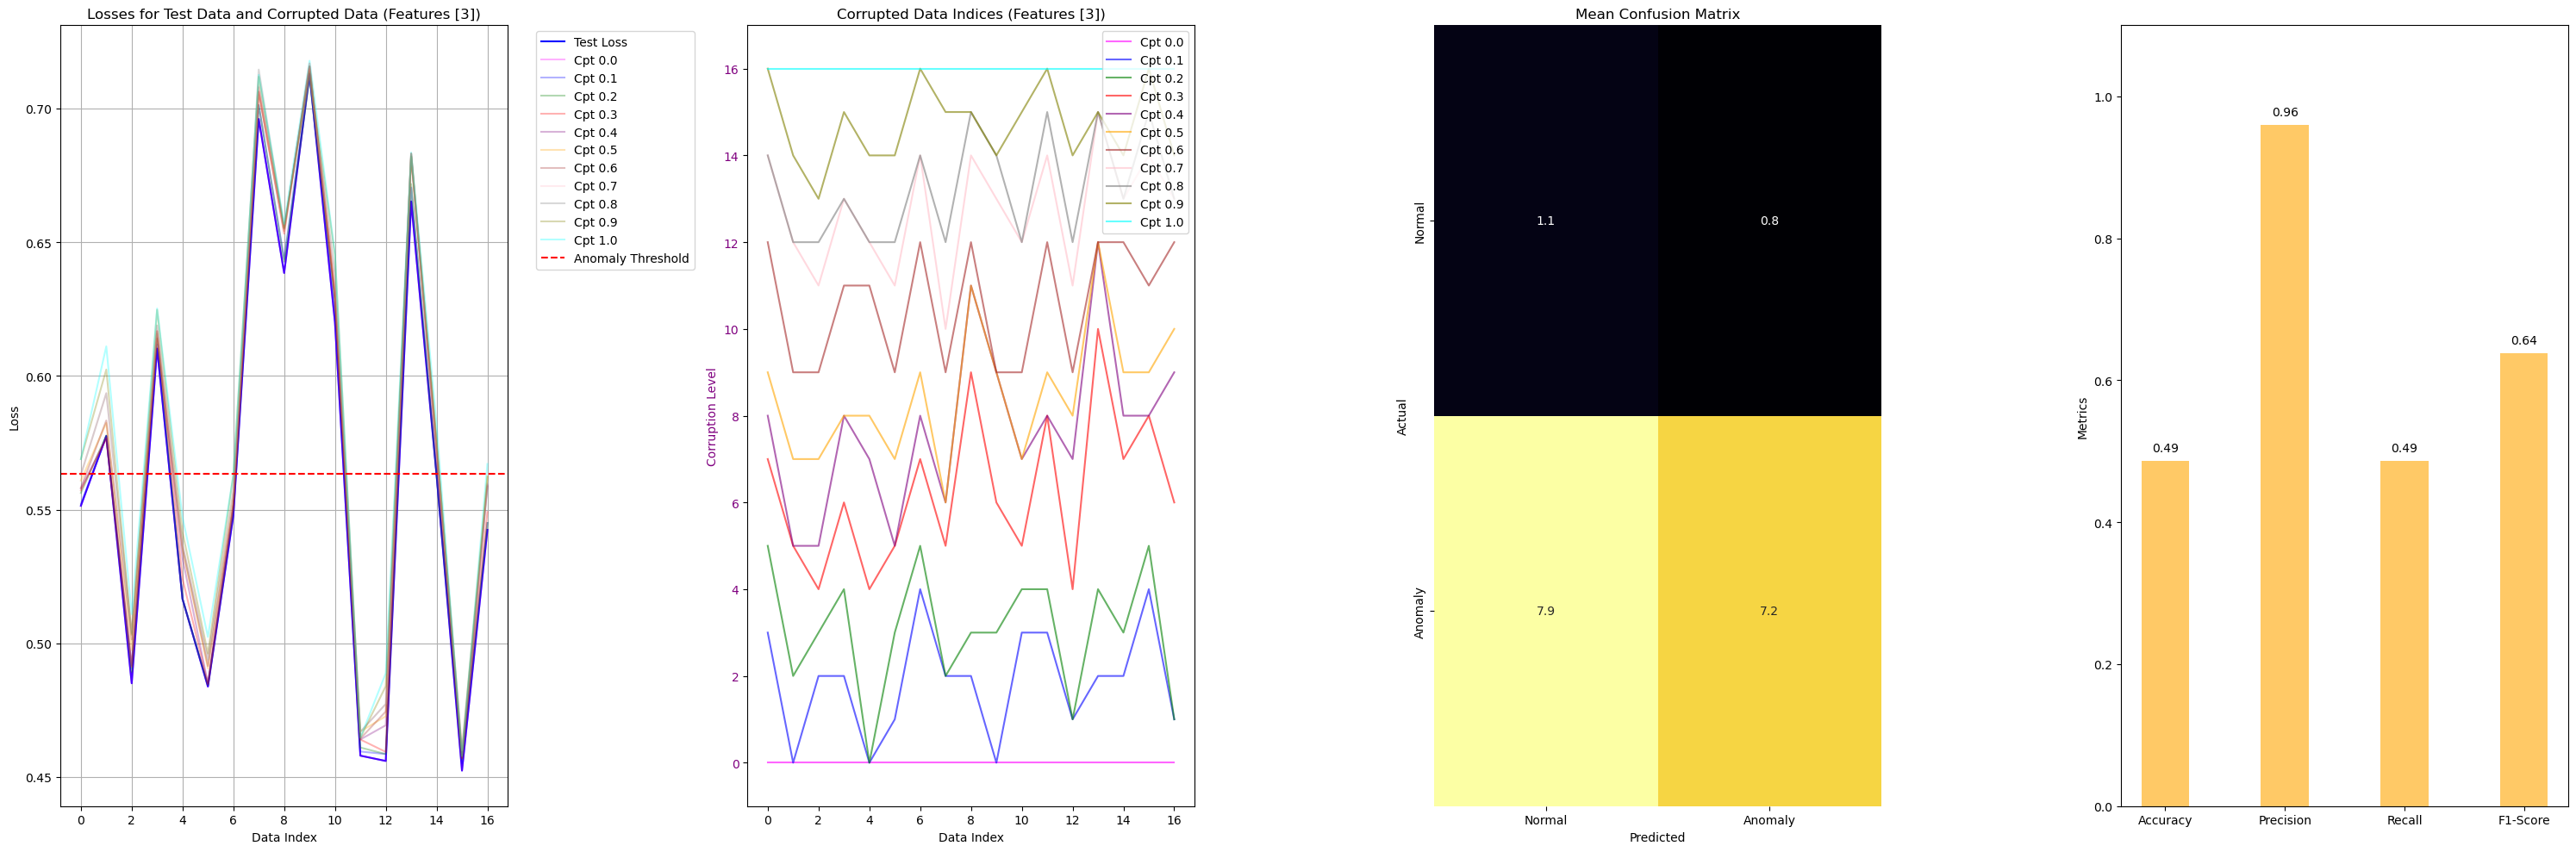

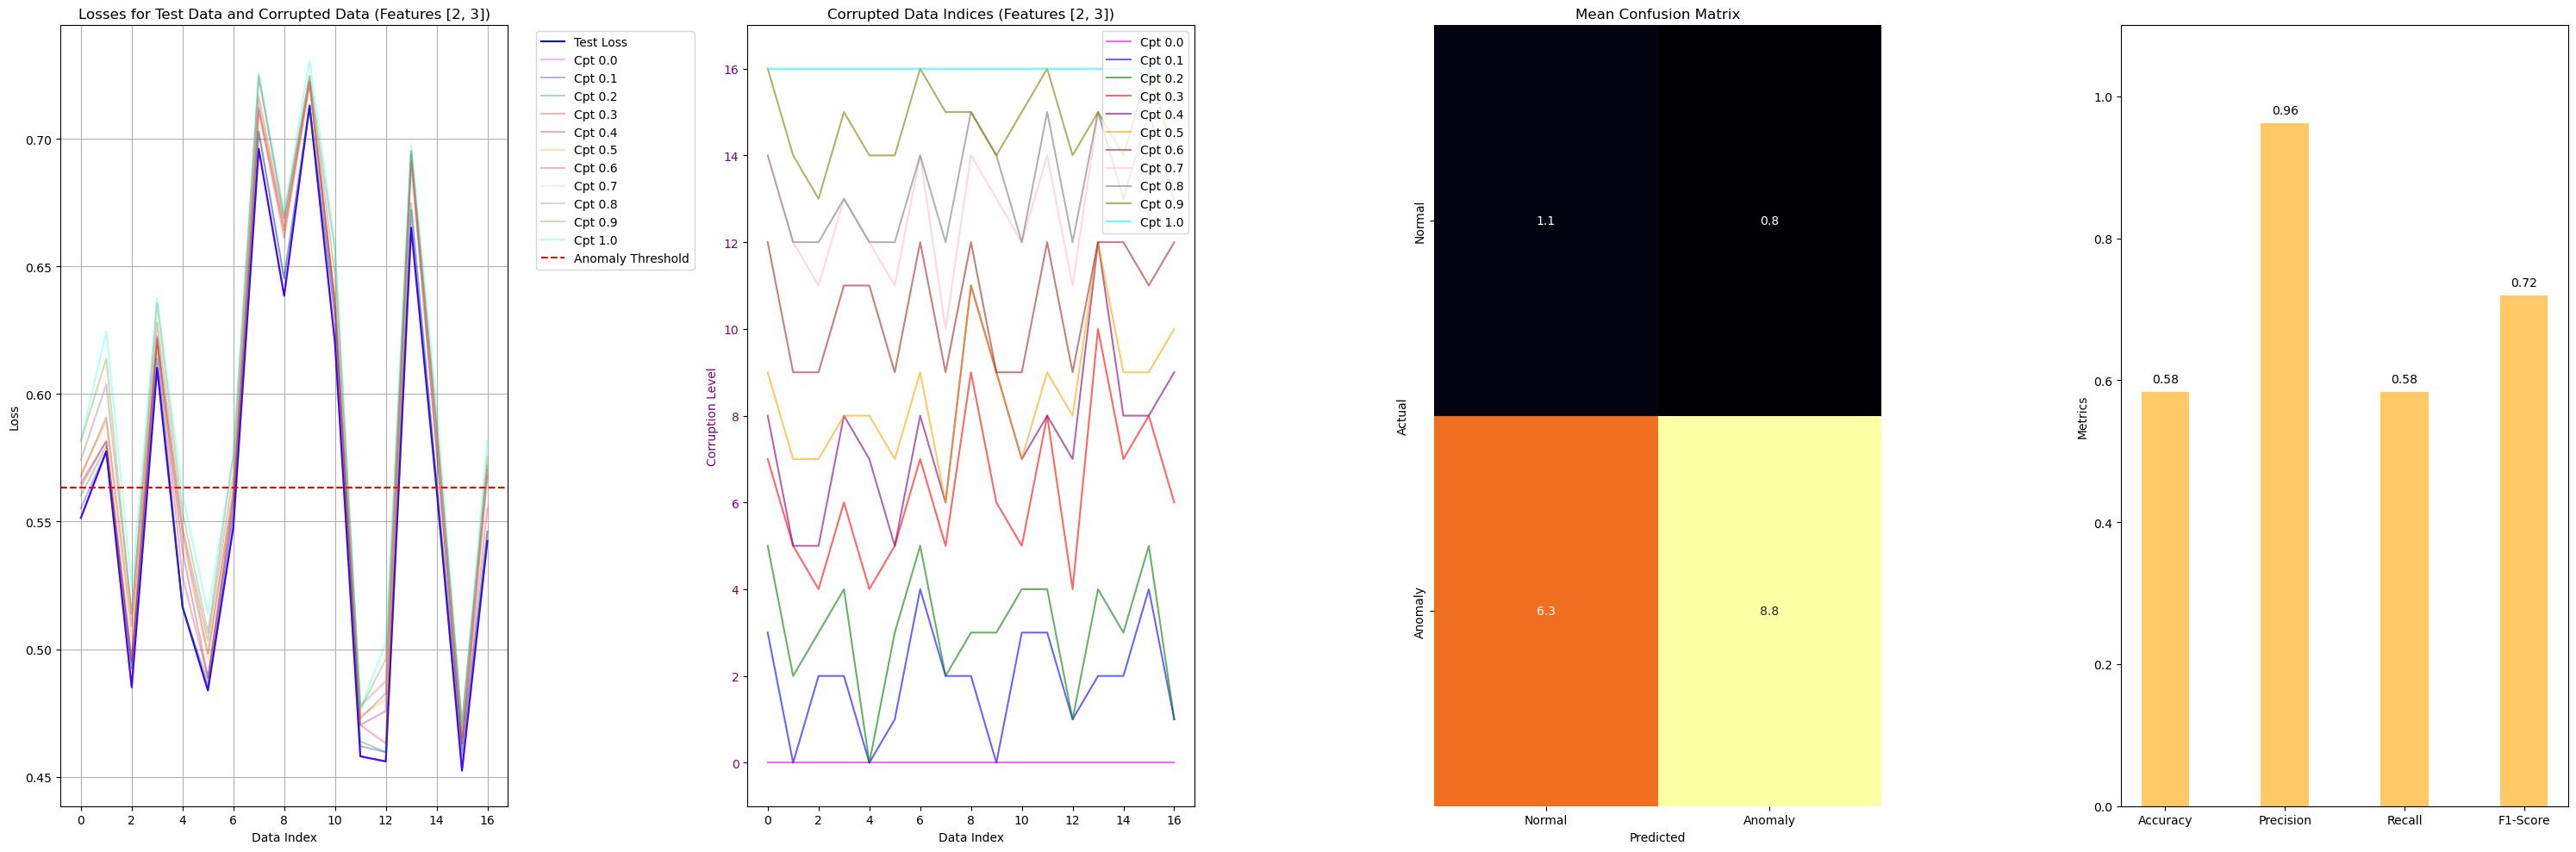

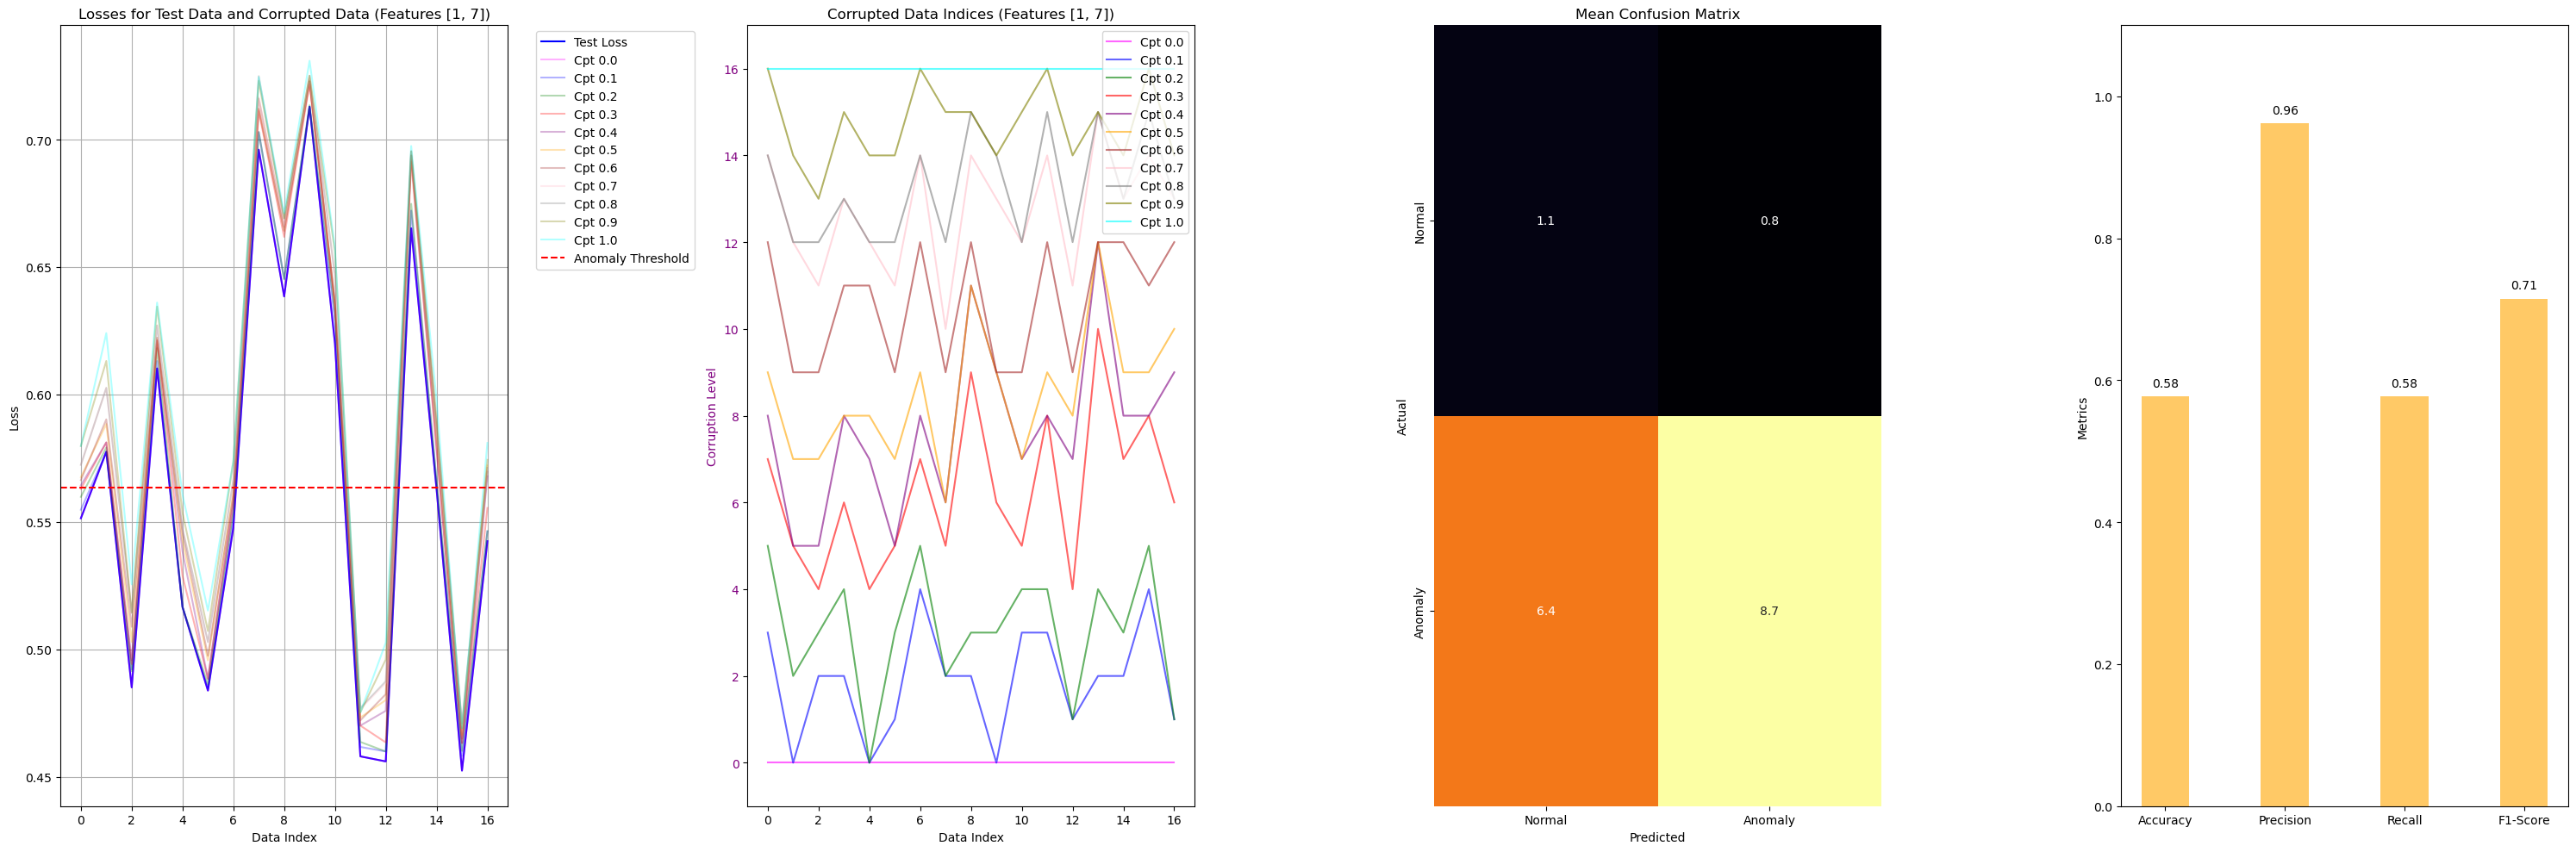

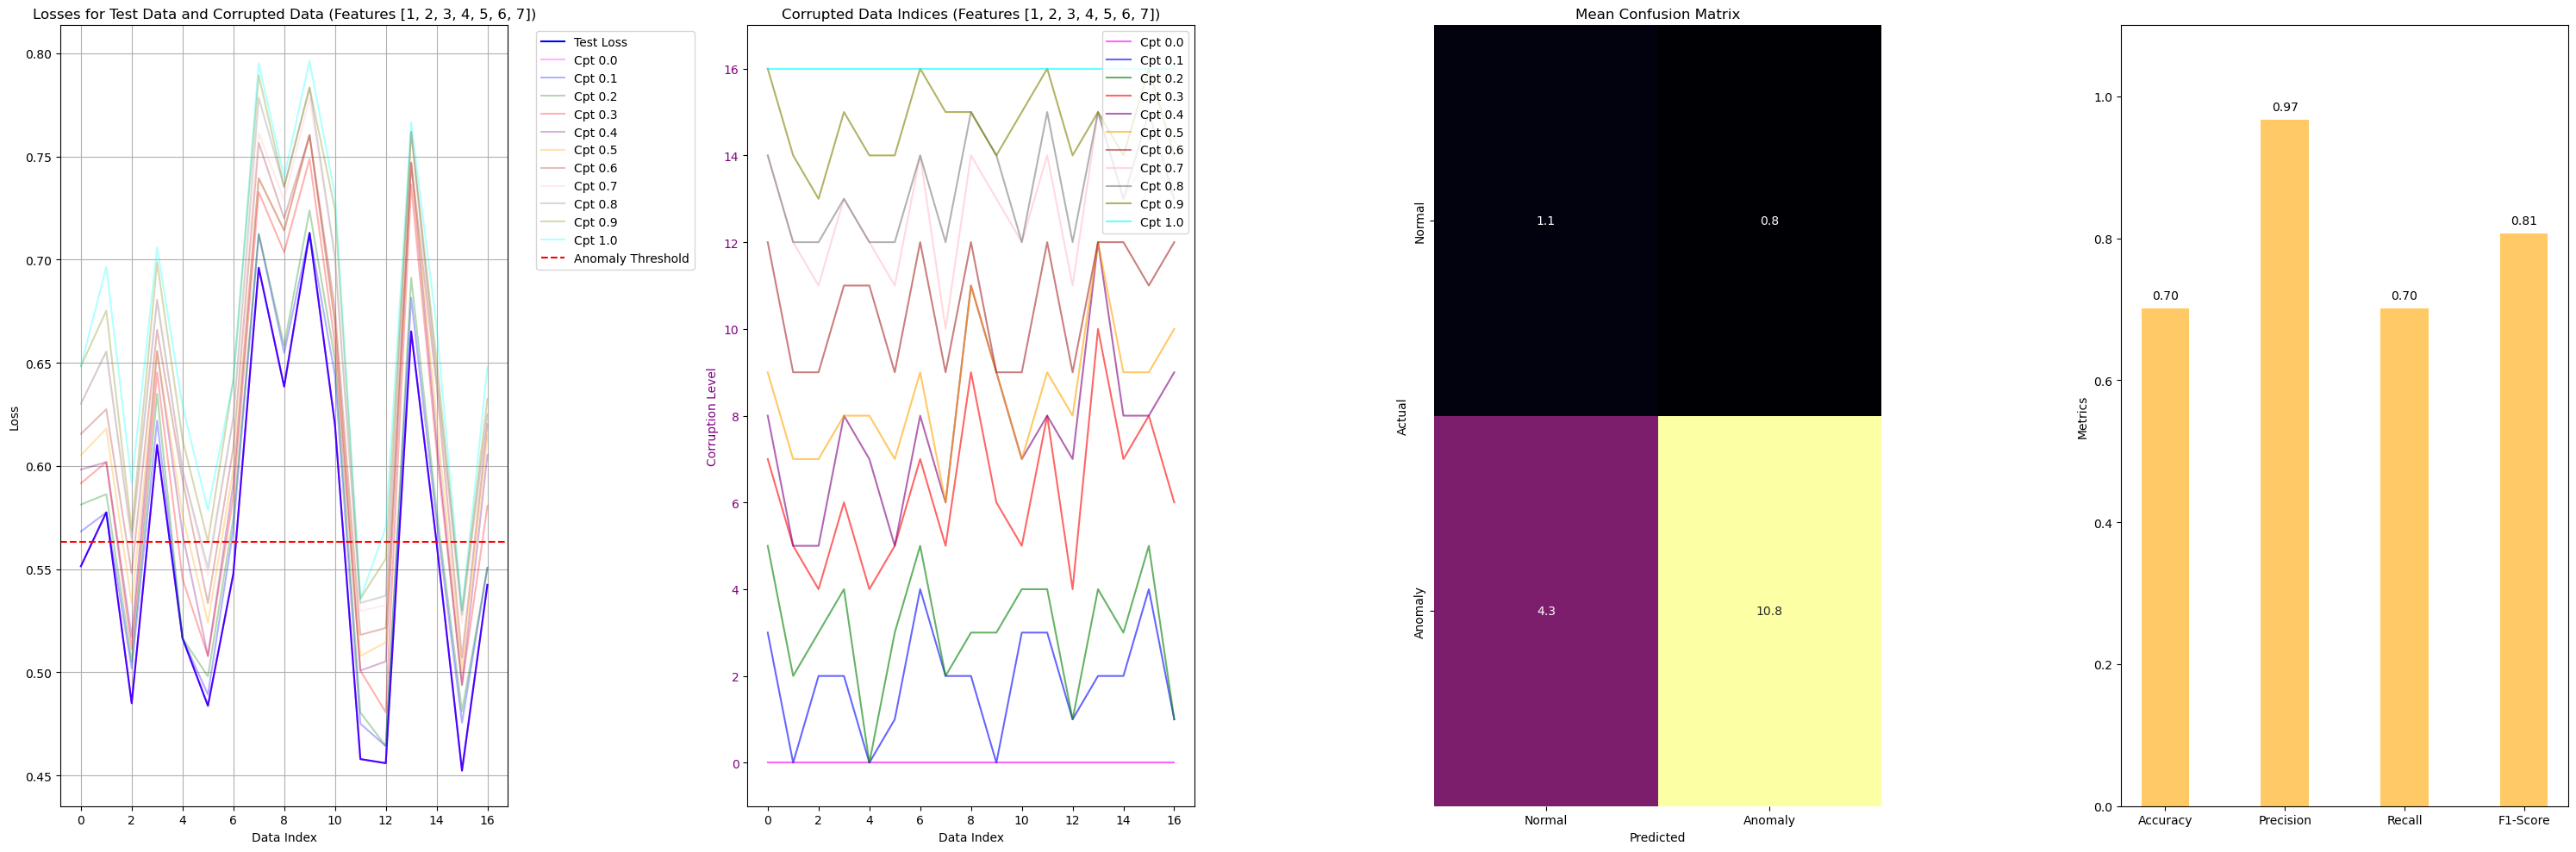

In [334]:
corruption_levels = [i / 10 for i in range(11)]  # Levels from 0.1 to 1.0
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta']

# Loop through each pair of feature indices
for pair in correlated_vars + low_correlated_vars + [[1, 2, 3, 4, 5, 6, 7]]:
    fig, axes = plt.subplots(1, 4, figsize=(30, 10))  # Three subplots: losses, corrupted data, and metrics

    ax1, ax2, ax3, ax4= axes

    # Original test losses
    ax1.plot(test_losses, label='Test Loss', color='blue')

    mean_class_rep = []
    mean_cm = []

    # Loop through corruption levels
    for corruption_level in corruption_levels:
        # Sort features without modifying the original `pair`
        sorted_pair = sorted(pair)

        # Generate folder corruption name
        FOLDER_CORRUPTION = '_'.join([str(mapping_variables[var]) for var in sorted_pair])

        # Load corrupted data
        _, indices, data_corrupted = load_data(DATA_PATH_TEST, DATA_PATH_CORRUPTED+FOLDER_CORRUPTION, corruption_level)
        indices = indices[int((TRAIN_RATIO + VAL_RATIO) * len(data_corrupted)):]
        data_corrupted = data_corrupted[int((TRAIN_RATIO + VAL_RATIO) * len(data_corrupted)):]

        corrupted_loader = DataLoader(data_corrupted, batch_size=TEST_BATCH_SIZE, shuffle=False)

        # Detect anomalies in the corrupted data
        corrupted_losses, _, corrupted_anomalies = detect_anomalies(model, corrupted_loader, criterion, threshold=anomaly_threshold)

        # Plot corrupted losses
        color_idx = min(int(corruption_level * 10) - 1, len(colors) - 1)
        ax1.plot(corrupted_losses, label=f'Cpt {corruption_level:.1f}', alpha=0.3, color=colors[color_idx])
        ax2.plot(indices, alpha=0.6, label=f'Cpt {corruption_level:.1f}', color=colors[color_idx])

        # Metrics calculations
        actual_anomalies = [1 if i > 0 else 0 for i in indices]
        predicted_anomalies = [1 if i in corrupted_anomalies else 0 for i in range(len(indices))]

        # Classification report and confusion matrix
        class_rep = classification_report(actual_anomalies, predicted_anomalies, target_names=['Normal', 'Anomaly'], output_dict=True, labels=[0, 1])
        cm = confusion_matrix(actual_anomalies, predicted_anomalies, labels=[0, 1])

        mean_class_rep.append(class_rep)
        mean_cm.append(cm)
  
    # Calculate mean metrics
    mean_cm = np.mean(mean_cm, axis=0)

    mean_accuracy = np.mean([rep['accuracy'] for rep in mean_class_rep])
    
    # Save list of reports
    with open(FOLDER_MODEL_SAVE + f'/corrupted_reports_{sorted_pair}.json', 'w') as f:
        json.dump(mean_class_rep, f, indent=4)

    # Prepare metrics for the bar plot
    mean_class_rep = {
        metric: np.mean([rep['weighted avg'][metric] for rep in mean_class_rep])
        for metric in ['precision', 'recall', 'f1-score']
    }

    

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metric_values = [mean_accuracy] + [mean_class_rep[m] for m in ['precision', 'recall', 'f1-score']]

    # Plot mean confusion matrix as heatmap
    sns.heatmap(mean_cm, annot=True, fmt='.1f', cmap='inferno', cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'], ax=ax3)
    ax3.set_title('Mean Confusion Matrix')
    ax3.set_xlabel('Predicted')
    ax3.set_ylabel('Actual')
    
    # Add bar plot to the same subplot
    ax4.bar(metrics, metric_values, alpha=0.6, color='orange', width=0.4)
    ax4.set_ylim(0, 1.1)
    ax4.set_ylabel('Metrics')
    
    # Print the legend with the values in ax4
    for i, v in enumerate(metric_values):
        ax4.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')

    # Plot threshold and titles
    ax1.axhline(anomaly_threshold, color='red', linestyle='--', label='Anomaly Threshold')
    ax1.set_xlabel('Data Index')
    ax1.set_ylabel('Loss')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True)
    ax1.set_title(f'Losses for Test Data and Corrupted Data (Features {pair})')

    # Secondary plot: corrupted indices
    ax2.set_ylabel('Corruption Level', color='purple')
    ax2.tick_params(axis='y', labelcolor='purple')
    ax2.set_ylim(-1, 17)
    ax2.legend(loc='upper right')
    ax2.set_xlabel('Data Index')
    ax2.set_title(f'Corrupted Data Indices (Features {pair})')

    plt.tight_layout()

    plt.savefig(FOLDER_MODEL_SAVE + f'/corrupted_losses_{FOLDER_CORRUPTION}.png')
    
    plt.show()


# Improvements
---

### 1. **Improve Temporal Convolutions**
   - **Depthwise Separable Convolutions**: Replace standard `Conv2d` with depthwise separable convolutions to reduce the parameter count while maintaining temporal feature extraction quality.
   - **Dilated Convolutions**: Introduce dilation to expand the receptive field without increasing kernel size.
   - **Residual Connections**: Add skip connections to ensure gradient flow and retain low-level temporal features.
   - **Normalization Layers**: Include batch normalization or layer normalization after convolution layers to stabilize training.

---

### 2. **Enhance Spatial Convolutions**
   - **Dynamic Graph Construction**: Instead of using static graph representations (`edge_index`, `edge_weight`), consider dynamically constructing the graph at each time step based on node interactions or learned adjacency matrices.
   - **Multi-Scale Aggregation**: Add multi-scale spatial convolutions to capture information at different neighborhood sizes.
   - **Attention Mechanisms**: Use graph attention networks (GATs) or temporal self-attention mechanisms to allow the model to focus on more critical spatial-temporal regions.

---

### 3. **Parameter Efficiency**
   - Use **shared weights** in spatial-temporal convolution layers across similar operations.
   - Reduce redundant parameters in `SimpleTemporalConv` and `SimpleTemporalDeConv` by reusing convolution filters or merging operations.

---

### 4. **Architecture Improvements**
   - **Add Dropout Layers**: Introduce dropout layers to reduce overfitting, particularly in deeper layers or after graph convolutions.
   - **Hierarchical Encoding**: Stack multiple encoders and decoders with residual connections to learn hierarchical spatial-temporal features.
   - **Latent Space Regularization**: Use techniques like variational autoencoders to enforce structured learning in the latent space.
   - **Channel Attention**: Use squeeze-and-excitation or channel attention mechanisms to learn the importance of different feature channels dynamically.

---

### 5. **Better Handling of Input/Output Shapes**
   - Automate shape calculations in temporal convolution layers using `nn.Conv2d` with appropriate padding to avoid manual permutation operations.
   - Add comments and assertions to ensure shape consistency.

---

### 6. **Training Optimizations**
   - **Loss Functions**: Use more tailored loss functions like reconstruction loss combined with perceptual loss to improve feature preservation.
   - **Learning Rate Scheduler**: Implement a learning rate scheduler (e.g., cosine annealing) to optimize training.
   - **Early Stopping and Validation**: Add early stopping criteria to prevent overfitting and validate performance at every epoch.

---

### 7. **Dynamic Adjustments**
   - Add support for **dynamic edge weights** in `SimpleSpatialConv` to enable adaptability during training.
   - Consider integrating Graph Neural Network (GNN) layers like GraphSAGE or DGI for richer feature extraction.

---

### 8. **Code Refactoring**
   - Encapsulate repeated patterns (e.g., graph and temporal convolutions) into modular blocks to improve readability.
   - Use `torch.nn.Sequential` where possible to simplify the layer definitions.

---

### Example Enhanced `SimpleTemporalConv`
```python
class EnhancedTemporalConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(EnhancedTemporalConv, self).__init__()
        self.depthwise_conv = nn.Conv2d(
            in_channels, in_channels, (1, kernel_size),
            stride=(1, stride), padding=(0, padding), groups=in_channels
        )
        self.pointwise_conv = nn.Conv2d(in_channels, out_channels, (1, 1))
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = x.permute(0, 3, 2, 1)  # (B, T, N, C) -> (B, C, N, T)
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        x = self.bn(x)
        x = F.relu(x)
        x = x.permute(0, 3, 2, 1)  # Back to (B, T, N, C)
        return x
```

### Example Enhanced `SimpleSpatialConv`
```python
class EnhancedSpatialConv(nn.Module):
    def __init__(self, in_channels, out_channels, K, normalization='sym', bias=False):
        super(EnhancedSpatialConv, self).__init__()
        self.conv = ChebConv(in_channels, out_channels, K, normalization=normalization, bias=bias)
        self.attention = nn.Parameter(torch.ones(K))

    def forward(self, x, edge_index, edge_weight):
        batch_size, time_steps, num_nodes, _ = x.size()
        output = torch.zeros(batch_size, time_steps, num_nodes, self.conv.out_channels, device=x.device)
        for t in range(time_steps):
            attention_weights = F.softmax(self.attention, dim=0)
            output[:, t] = F.relu(self.conv(x[:, t], edge_index, edge_weight) * attention_weights)
        return output
```

These enhancements will improve computational efficiency, generalization, and the model’s ability to capture complex spatial-temporal dependencies.